<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment9/IDL_Assignment_9_Govind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Team


1.   Govind Shukla (235192)
2.   Meghana Rao (234907)
3.   Srinath Mannam (229750)

# Imports

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
import os
os.chdir("/content/drive/MyDrive/IDL_Lecture")

#Convolution AutoEncoder

In [41]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32) / 255
y_train = y_train.astype(np.int32)
x_test = x_test.reshape(-1, 28, 28, 1).astype(np.float32) / 255
y_test = y_test.astype(np.int32)

print (x_train.shape)
print(y_train.shape)
print (x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [44]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(x_train,
                                                             x_train,
                                                             test_size=0.2,
                                                             random_state=13)

In [62]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).batch(128)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [47]:
batch_size = 64
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = tf.keras.layers.Input(shape = (x, y, inChannel))
num_classes = 10

In [48]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    conv6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    up1 = tf.keras.layers.UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    up2 = tf.keras.layers.UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [49]:
def classification_head(encoder):
    flat = tf.keras.layers.Flatten()(encoder)
    den = tf.keras.layers.Dense(128, activation='relu')(flat)
    out = tf.keras.layers.Dense(num_classes)(den)
    return out

In [50]:
encode = encoder(input_img)
full_model = Model(input_img,classification_head(encode))

In [51]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = tf.optimizers.Adam())

In [52]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [53]:
autoencoder.get_weights()[0][1]

array([[[ 0.08974802, -0.14175591, -0.09255566,  0.07821232,
         -0.0504958 ,  0.12834387,  0.03327467,  0.1190037 ,
          0.02993008,  0.073513  ,  0.06739552,  0.03444903,
         -0.07257639,  0.03437658,  0.02653047, -0.01382235,
         -0.09082621, -0.02370613,  0.05133569, -0.05706005,
         -0.09366336, -0.04020631, -0.07510052,  0.12242348,
          0.10286053, -0.10460535,  0.00696334, -0.01215796,
          0.10419145,  0.10141388,  0.02904488,  0.09334868]],

       [[ 0.1141188 ,  0.04050401,  0.1412374 , -0.02764641,
          0.133305  ,  0.0695928 , -0.00107209,  0.05275364,
          0.08469576,  0.04160216,  0.08092891,  0.13663553,
          0.05269831,  0.09755529, -0.09987864, -0.06421411,
          0.13931917,  0.01487288, -0.00384696, -0.08741491,
         -0.04354636,  0.08990894,  0.01968051, -0.0955009 ,
         -0.07168058,  0.12203629,  0.06074317,  0.09850769,
          0.12376668,  0.14100398,  0.07431222,  0.03940935]],

       [[ 0.127980

In [54]:
full_model.get_weights()[0][1]

array([[[ 0.08974802, -0.14175591, -0.09255566,  0.07821232,
         -0.0504958 ,  0.12834387,  0.03327467,  0.1190037 ,
          0.02993008,  0.073513  ,  0.06739552,  0.03444903,
         -0.07257639,  0.03437658,  0.02653047, -0.01382235,
         -0.09082621, -0.02370613,  0.05133569, -0.05706005,
         -0.09366336, -0.04020631, -0.07510052,  0.12242348,
          0.10286053, -0.10460535,  0.00696334, -0.01215796,
          0.10419145,  0.10141388,  0.02904488,  0.09334868]],

       [[ 0.1141188 ,  0.04050401,  0.1412374 , -0.02764641,
          0.133305  ,  0.0695928 , -0.00107209,  0.05275364,
          0.08469576,  0.04160216,  0.08092891,  0.13663553,
          0.05269831,  0.09755529, -0.09987864, -0.06421411,
          0.13931917,  0.01487288, -0.00384696, -0.08741491,
         -0.04354636,  0.08990894,  0.01968051, -0.0955009 ,
         -0.07168058,  0.12203629,  0.06074317,  0.09850769,
          0.12376668,  0.14100398,  0.07431222,  0.03940935]],

       [[ 0.127980

In [55]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_38 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_40 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_39 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0   

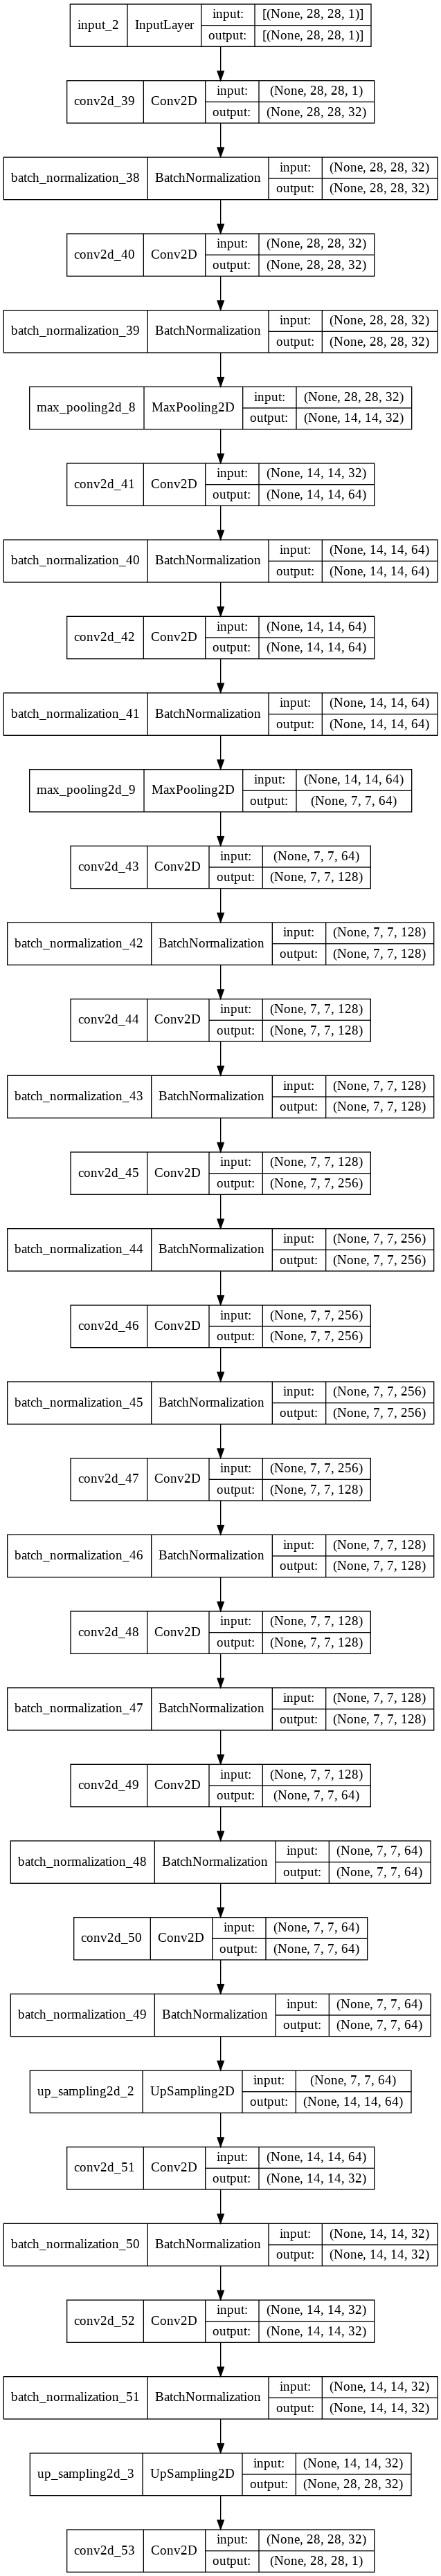

In [68]:
# plot the autoencoder
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, 'autoencoder_no_compress.png', show_shapes=True)

In [56]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/20
750/750 [==============================] - 38s 49ms/step - loss: 0.0156 - val_loss: 0.0096
Epoch 2/20
750/750 [==============================] - 32s 43ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 3/20
750/750 [==============================] - 33s 44ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 4/20
750/750 [==============================] - 33s 44ms/step - loss: 0.0059 - val_loss: 0.2690
Epoch 5/20
750/750 [==============================] - 32s 43ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 6/20
750/750 [==============================] - 33s 44ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 7/20
750/750 [==============================] - 32s 43ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 8/20
750/750 [==============================] - 33s 44ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 9/20
750/750 [==============================] - 32s 43ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 10/20
750/750 [==============================] - 32s 43ms/step - loss: 0.003

##Freeze

In [57]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [58]:
full_model.compile( optimizer=tf.optimizers.Adam(), loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = tf.metrics.SparseCategoricalAccuracy())


In [59]:
full_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_30 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_31 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0   

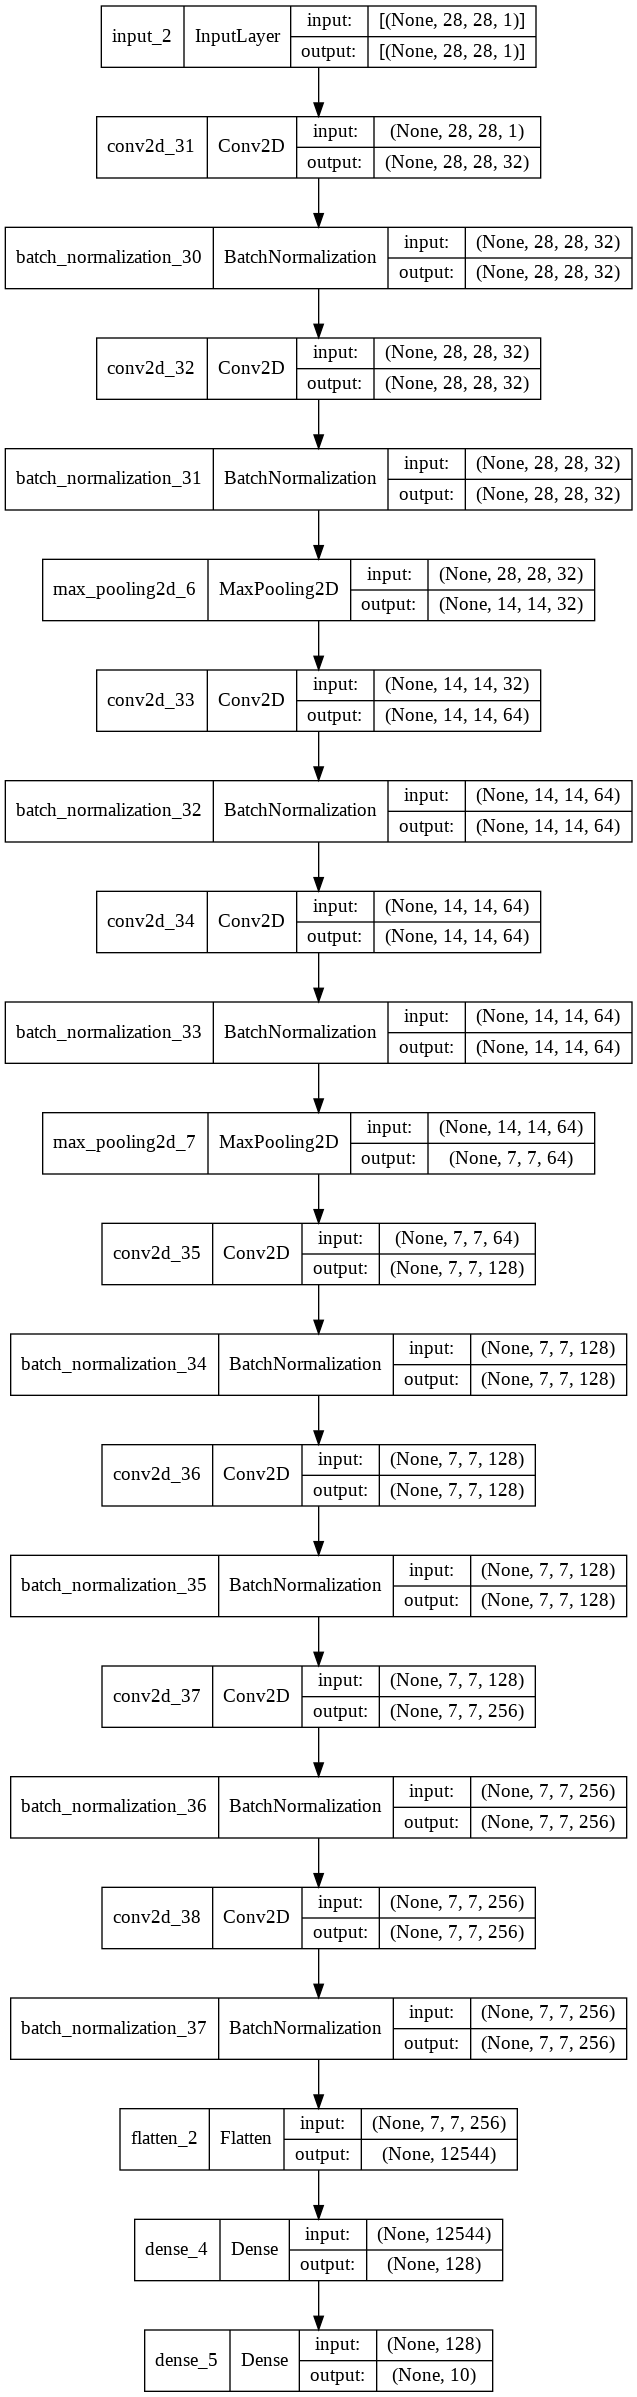

In [69]:
# plot the classifier
plot_model(full_model, 'full_model.png', show_shapes=True)

In [60]:
classify_train = full_model.fit(train_data,
                                epochs=20,
                                shuffle=True)

Epoch 1/20
469/469 [==============================] - 9s 16ms/step - loss: 1.0175 - sparse_categorical_accuracy: 0.6738
Epoch 2/20
469/469 [==============================] - 8s 16ms/step - loss: 0.6010 - sparse_categorical_accuracy: 0.7817
Epoch 3/20
469/469 [==============================] - 8s 16ms/step - loss: 0.5164 - sparse_categorical_accuracy: 0.8152
Epoch 4/20
469/469 [==============================] - 8s 16ms/step - loss: 0.4698 - sparse_categorical_accuracy: 0.8338
Epoch 5/20
469/469 [==============================] - 8s 16ms/step - loss: 0.4397 - sparse_categorical_accuracy: 0.8460
Epoch 6/20
469/469 [==============================] - 7s 16ms/step - loss: 0.4163 - sparse_categorical_accuracy: 0.8535
Epoch 7/20
469/469 [==============================] - 7s 16ms/step - loss: 0.3991 - sparse_categorical_accuracy: 0.8607
Epoch 8/20
469/469 [==============================] - 8s 16ms/step - loss: 0.3846 - sparse_categorical_accuracy: 0.8649
Epoch 9/20
469/469 [====================

##Unfreeze

In [65]:
for layer in full_model.layers[0:19]:
    layer.trainable = True
full_model.compile( optimizer=tf.optimizers.Adam(), loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = tf.metrics.SparseCategoricalAccuracy())
full_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_30 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_31 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0   

In [66]:
classify_train = full_model.fit(train_data,
                                epochs=20,
                                shuffle=True)

Epoch 1/20
469/469 [==============================] - 80s 43ms/step - loss: 9.3254 - sparse_categorical_accuracy: 0.7840
Epoch 2/20
469/469 [==============================] - 21s 44ms/step - loss: 0.3845 - sparse_categorical_accuracy: 0.8615
Epoch 3/20
469/469 [==============================] - 22s 46ms/step - loss: 0.3121 - sparse_categorical_accuracy: 0.8858
Epoch 4/20
469/469 [==============================] - 20s 43ms/step - loss: 0.2807 - sparse_categorical_accuracy: 0.8984
Epoch 5/20
469/469 [==============================] - 20s 43ms/step - loss: 0.3049 - sparse_categorical_accuracy: 0.8985
Epoch 6/20
469/469 [==============================] - 20s 43ms/step - loss: 0.4813 - sparse_categorical_accuracy: 0.8436
Epoch 7/20
469/469 [==============================] - 20s 42ms/step - loss: 0.3173 - sparse_categorical_accuracy: 0.8857
Epoch 8/20
469/469 [==============================] - 20s 43ms/step - loss: 0.2882 - sparse_categorical_accuracy: 0.8971
Epoch 9/20
469/469 [============

#Basic and Denoising Autoencoder

## Original Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = (x_train.astype('float32') / 255)
x_test = (x_test.astype('float32') / 255)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(x_train.shape[0]).batch(512)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(100)

# pick a random subset
labeled_indices = np.random.choice(60000, replace=False, size=1000)

print("Original Dataset Size")
print ("Train Dataset Size: ", x_train.shape)
print ("Test Dataset Size: ", x_test.shape)

Original Dataset Size
Train Dataset Size:  (60000, 28, 28)
Test Dataset Size:  (10000, 28, 28)


## AutoEncoder1 Dataset

In [ ]:
auto_train_data = tf.data.Dataset.from_tensor_slices((x_train, x_train)).shuffle(x_train.shape[0]).batch(512)
auto_test_data = tf.data.Dataset.from_tensor_slices((x_test, x_test)).batch(100)

# choose corresponding images and labels
x_train_subset = x_train[labeled_indices]
y_train_subset = y_train[labeled_indices]

train_subset_data = tf.data.Dataset.from_tensor_slices((x_train_subset, y_train_subset)).shuffle(x_train_subset.shape[0]).batch(100)

print("Subset Dataset Size")
print ("Train Subset Dataset Size: ", x_train_subset.shape)

Subset Dataset Size
Train Subset Dataset Size:  (1000, 28, 28)


## AutoEncoder2 Denoise Dataset

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

train_noisy_data = tf.data.Dataset.from_tensor_slices((x_train_noisy, y_train)).shuffle(x_train.shape[0]).batch(512)
test_noisy_data = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test)).batch(100)

auto2_train_data = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train)).shuffle(x_train.shape[0]).batch(512)
auto2_test_data = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test)).batch(100)

x_train_noisy_subset = []
# choose corresponding images and labels
for index in labeled_indices:
    x_train_noisy_subset.append(x_train_noisy[index])
x_train_noisy_subset = np.array(x_train_noisy_subset)
y_train_subset = y_train[labeled_indices]

train_noisy_subset_data = tf.data.Dataset.from_tensor_slices((x_train_noisy_subset, y_train_subset)).shuffle(x_train_noisy_subset.shape[0]).batch(100)

print("Noisy Subset Dataset Size")
print ("Train Subset Dataset Size: ", x_train_noisy_subset.shape)

Noisy Subset Dataset Size
Train Subset Dataset Size:  (1000, 28, 28)


##Model1

Summary:



*   Built an auto-Encoder with Encoder, Decoder Architecture.
*   This model will try to make input images to lower space and again try to 
reconstruct from the bottleneck.
* All the model layers are Dense layers like MLP.
*   Classifier - 1
  - Trained Encoder Model with additional classification layers.
  - Trained on sub-set data which is 1000 samples.
  - Training Accuracy is 87.1%
  - Test Accuracy is 76.4%
*   Classifier - 2
  - Created an Entire Architecture like the above classifier with encoder + additional classification layers.
  - But here the encoder is not pre-trained(from AutoEncoder) or freezed.
  - Entire training data has been used.
  - Training Accuracy is 82.97%
  - Test Accuracy is 82.09%
*   Classifier - 3
  - Same architecture as classifier 2.
  - Train data is only sub-set of 1000 samples.
  - Training Accuracy is 89.3%
  - Test Accuracy is 77.85%






## Definition

In [ ]:
bottleNeck = 64
input_shape = (28, 28)

#Encoder
image_input = tf.keras.Input(input_shape)  # flattened 28x28 MNIST images
flatten = tf.keras.layers.Flatten()(image_input)
enc_Layer1 = tf.keras.layers.Dense(256)(flatten)
enc_Layer2 = tf.keras.layers.Dense(128)(enc_Layer1)
encoding = tf.keras.layers.Dense(bottleNeck)(enc_Layer2)
encoder = tf.keras.Model(image_input, encoding, name="Encoder")

#Decoder
code_input = tf.keras.Input((bottleNeck,))
dec_Layer1 = tf.keras.layers.Dense(128)(code_input)
dec_Layer2 = tf.keras.layers.Dense(256)(dec_Layer1)
decoding = tf.keras.layers.Dense(784, tf.nn.sigmoid)(dec_Layer2)
decoding2 = tf.keras.layers.Reshape(input_shape)(decoding)
decoder = tf.keras.Model(code_input, decoding2, name="Decoder")

#Auto-Encoder
autoencoder = tf.keras.Model(image_input, decoder(encoder(image_input)), name="AutoEncoder")

# Extended Model Head for Classification
layer1 =  tf.keras.layers.Dense(512)(encoding)
layer2 =  tf.keras.layers.Dense(256)(layer1)

logits = tf.keras.layers.Dense(10)(layer2)

classifier = tf.keras.Model(image_input, logits, name="Classifer")


#Classifier 2
c2_flatten = tf.keras.layers.Flatten()(image_input)
c2_layer1 = tf.keras.layers.Dense(256)(c2_flatten)
c2_layer2 = tf.keras.layers.Dense(128)(c2_layer1)
c2_layer3 = tf.keras.layers.Dense(bottleNeck)(c2_layer2)
c2_layer4 =  tf.keras.layers.Dense(512)(c2_layer3)
c2_layer5 =  tf.keras.layers.Dense(256)(c2_layer4)
c2_logits = tf.keras.layers.Dense(10)(layer2)
classifier2 = tf.keras.Model(image_input, c2_logits, name="Classifer2")
classifier3 = tf.keras.Model(image_input, c2_logits, name="Classifer3")


## Model Summary

In [ ]:
encoder.summary()
decoder.summary()
autoencoder.summary()
classifier.summary()
classifier2.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
Total params: 242,112
Trainable params: 242,112
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
____________________________________

## Model Training

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(auto_train_data,
                epochs=10)

Epoch 1/10
118/118 [==============================] - 3s 6ms/step - loss: 0.0457
Epoch 2/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0200
Epoch 3/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0164
Epoch 4/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0144
Epoch 5/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0131
Epoch 6/10
118/118 [==============================] - 1s 5ms/step - loss: 0.0123
Epoch 7/10
118/118 [==============================] - 1s 6ms/step - loss: 0.0116
Epoch 8/10
118/118 [==============================] - 1s 6ms/step - loss: 0.0112
Epoch 9/10
118/118 [==============================] - 1s 6ms/step - loss: 0.0108
Epoch 10/10
118/118 [==============================] - 1s 6ms/step - loss: 0.0104


## Model Testing

In [ ]:
autoencoder.evaluate(auto_test_data)

100/100 [==============================] - 0s 2ms/step - loss: 0.0104


0.010365966707468033

In [ ]:
encoded_imgs = encoder(x_test).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

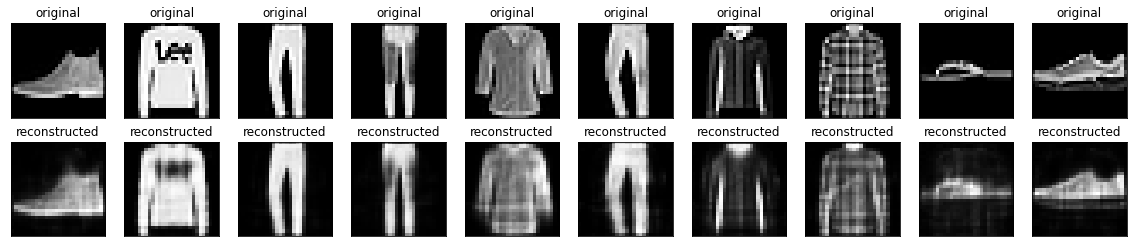

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Transfer Learning on 1000 samples

In [ ]:
encoder.trainable = False  # Freeze the encoder!
print("ENCODER")  # no more trainable variables
print(encoder.trainable_variables)

ENCODER
[]


In [ ]:
classifier.compile( optimizer=tf.optimizers.Adam(), 
                    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics   = tf.metrics.SparseCategoricalAccuracy(),)

In [ ]:
classifier.summary()

Model: "Classifer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 512)               33280     
                                                                 
 dense_7 (Dense)             (None, 256)               13

In [ ]:
classifier.fit(train_subset_data,
               epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 2ms/step - loss: 1.1878 - sparse_categorical_accuracy: 0.6060
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5846 - sparse_categorical_accuracy: 0.8120
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5284 - sparse_categorical_accuracy: 0.8180
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5118 - sparse_categorical_accuracy: 0.8170
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4818 - sparse_categorical_accuracy: 0.8430
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4142 - sparse_categorical_accuracy: 0.8520
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.3954 - sparse_categorical_accuracy: 0.8620
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3675 - sparse_categorical_accuracy: 0.8770
Epoch 9/10
10/10 [==============================] - 0s 2ms/step 

### Test Accuracy

In [ ]:
classifier.evaluate(test_data)

100/100 [==============================] - 0s 2ms/step - loss: 0.7607 - sparse_categorical_accuracy: 0.7648


[0.7607427835464478, 0.7648000121116638]

## Classifier 2

In [ ]:
classifier2.compile( optimizer=tf.optimizers.Adam(), 
                    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics   = tf.metrics.SparseCategoricalAccuracy(),)

In [ ]:
classifier2.fit(train_data,
               epochs=10)

Epoch 1/10
118/118 [==============================] - 1s 4ms/step - loss: 0.5850 - sparse_categorical_accuracy: 0.7974
Epoch 2/10
118/118 [==============================] - 0s 3ms/step - loss: 0.5055 - sparse_categorical_accuracy: 0.8216
Epoch 3/10
118/118 [==============================] - 0s 4ms/step - loss: 0.5001 - sparse_categorical_accuracy: 0.8227
Epoch 4/10
118/118 [==============================] - 0s 4ms/step - loss: 0.4960 - sparse_categorical_accuracy: 0.8249
Epoch 5/10
118/118 [==============================] - 0s 3ms/step - loss: 0.4888 - sparse_categorical_accuracy: 0.8274
Epoch 6/10
118/118 [==============================] - 0s 3ms/step - loss: 0.4877 - sparse_categorical_accuracy: 0.8282
Epoch 7/10
118/118 [==============================] - 0s 3ms/step - loss: 0.4864 - sparse_categorical_accuracy: 0.8282
Epoch 8/10
118/118 [==============================] - 0s 3ms/step - loss: 0.4824 - sparse_categorical_accuracy: 0.8300
Epoch 9/10
118/118 [============================

In [ ]:
classifier2.evaluate(test_data)

100/100 [==============================] - 0s 2ms/step - loss: 0.5114 - sparse_categorical_accuracy: 0.8209


[0.5113542079925537, 0.820900022983551]

## Classifier 3

Pre-training for low supervision scenarios

In [ ]:
classifier3.compile( optimizer=tf.optimizers.Adam(), 
                    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics   = tf.metrics.SparseCategoricalAccuracy(),)

In [ ]:
classifier3.fit(train_subset_data,
               epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 2ms/step - loss: 0.4787 - sparse_categorical_accuracy: 0.8440
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3796 - sparse_categorical_accuracy: 0.8590
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3329 - sparse_categorical_accuracy: 0.8830
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3136 - sparse_categorical_accuracy: 0.8910
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3273 - sparse_categorical_accuracy: 0.8790
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.3025 - sparse_categorical_accuracy: 0.8900
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 0.2911 - sparse_categorical_accuracy: 0.8960
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 0.2787 - sparse_categorical_accuracy: 0.9020
Epoch 9/10
10/10 [==============================] - 0s 3ms/step 

In [ ]:
classifier3.evaluate(test_data)

100/100 [==============================] - 0s 2ms/step - loss: 0.7562 - sparse_categorical_accuracy: 0.7785


[0.7562354207038879, 0.7785000205039978]

## Model2

Summary:



*   Built an auto-Encoder with Encoder, Decoder Architecture.
*   This model will try to make input images to lower space and again try to 
reconstruct from the bottleneck.
* All the model layers are CNN's.
*   Classifier - 1
  - Trained Encoder Model with additional classification layers.
  - Trained on sub-set data which is 1000 samples.
  - Training Accuracy is 83.1%
  - Test Accuracy is 75.65%
*   Classifier - 2
  - Created an Entire Architecture like the above classifier with encoder + additional classification layers.
  - But here the encoder is not pre-trained(from AutoEncoder) or freezed.
  - Entire training data has been used.
  - Training Accuracy is 83.75%
  - Test Accuracy is 82.91%

## Definition

In [ ]:
bottleNeck = (4, 4, 16)
input_shape = (28, 28, 1)

#Encoder
image_input = tf.keras.Input(input_shape)
m2_enc_Layer1 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding='same', strides=2)(image_input)
m2_encoding = tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding='same', strides=2)(m2_enc_Layer1)
m2_encoder = tf.keras.Model(image_input, m2_encoding, name="Encoder2")

#Decoder
m2_dec_Layer1 = tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(m2_encoding)
m2_dec_Layer2 = tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(m2_dec_Layer1)
m2_decoding = layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(m2_dec_Layer2)
m2_decoder = tf.keras.Model(m2_encoding, m2_decoding, name="Decoder2")

#Auto-Encoder
m2_autoencoder = tf.keras.Model(image_input, m2_decoder(m2_encoder(image_input)), name="AutoEncoder2")

# Extended Model Head for Classification
m2_flatten = tf.keras.layers.Flatten()(m2_encoding)
m2_layer1 =  tf.keras.layers.Dense(512)(m2_flatten)
m2_layer2 =  tf.keras.layers.Dense(256)(m2_layer1)

m2_logits = tf.keras.layers.Dense(10)(m2_layer2)

m2_classifier = tf.keras.Model(image_input, m2_logits, name="ClassiferV21")


#Classifier 2
m2_c2_inp = tf.keras.Input(input_shape)
m2_c2_layer1 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding='same', strides=2)(m2_c2_inp)
m2_c2_layer2 = tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation="relu", padding='same', strides=2)(m2_c2_layer1)
m2_c2_flatten = tf.keras.layers.Flatten()(m2_c2_layer2)
m2_c2_layer4 =  tf.keras.layers.Dense(512)(m2_c2_flatten)
m2_c2_layer5 =  tf.keras.layers.Dense(256)(m2_c2_layer4)
m2_c2_logits = tf.keras.layers.Dense(10)(m2_layer2)
m2_classifier2 = tf.keras.Model(image_input, m2_c2_logits, name="ClassiferV22")


## Model Summary

In [ ]:
m2_encoder.summary()
m2_decoder.summary()
m2_autoencoder.summary()
m2_classifier.summary()
m2_classifier2.summary()

Model: "Encoder2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 7, 8)]         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 1

## Model Training

In [ ]:
m2_autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
m2_autoencoder.fit(auto2_train_data,
                epochs=10)

Epoch 1/10
118/118 [==============================] - 9s 13ms/step - loss: 0.0962
Epoch 2/10
118/118 [==============================] - 2s 13ms/step - loss: 0.0268
Epoch 3/10
118/118 [==============================] - 2s 12ms/step - loss: 0.0156
Epoch 4/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0136
Epoch 5/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0126
Epoch 6/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0119
Epoch 7/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0114
Epoch 8/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0109
Epoch 9/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0105
Epoch 10/10
118/118 [==============================] - 1s 10ms/step - loss: 0.0103


## Model Testing

In [ ]:
m2_autoencoder.evaluate(auto2_test_data)

100/100 [==============================] - 0s 3ms/step - loss: 0.0103


0.010326802730560303

In [ ]:
m2_encoded_imgs = m2_encoder(x_test_noisy).numpy()
m2_decoded_imgs = m2_decoder(m2_encoded_imgs).numpy()

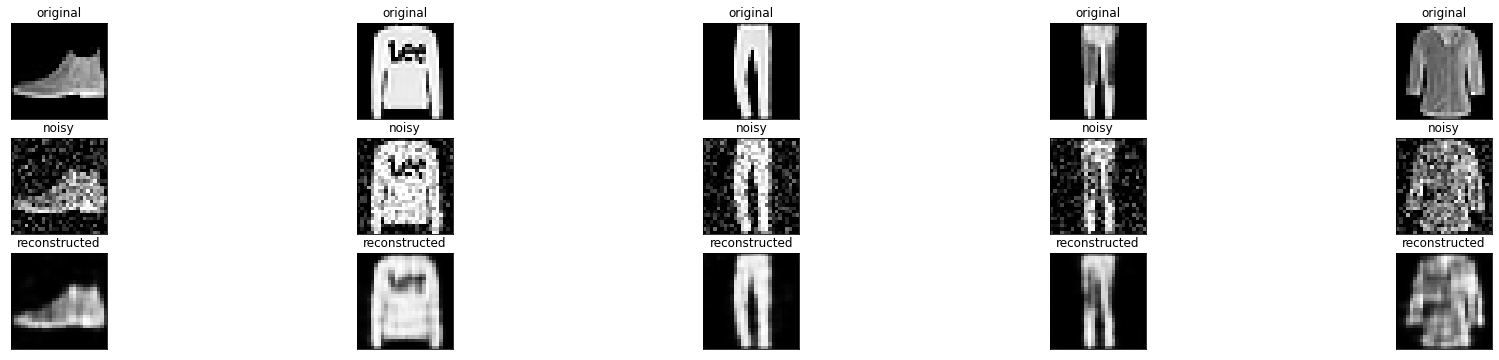

In [ ]:
n = 5
plt.figure(figsize=(30, 6))
for i in range(n):
  # display original
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display noisy
  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(x_test_noisy[i])
  plt.title("noisy")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, n, i + 1 + n + n)
  m2_dec = np.squeeze(m2_decoded_imgs[i], axis=-1)
  plt.imshow(m2_dec)
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Transfer Learning on 1000 samples

In [ ]:
m2_encoder.trainable = False  # Freeze the encoder!
print("ENCODER")  # no more trainable variables
print(m2_encoder.trainable_variables)

ENCODER
[]


In [ ]:
m2_classifier.compile( optimizer=tf.optimizers.Adam(), 
                    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics   = tf.metrics.SparseCategoricalAccuracy(),)

In [ ]:
m2_classifier.summary()

Model: "ClassiferV21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 flatten_2 (Flatten)         (None, 392)               0         
                                                                 
 dense_15 (Dense)            (None, 512)               201216    
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 10)               

In [ ]:
m2_classifier.fit(train_noisy_subset_data,
               epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 3ms/step - loss: 3.5170 - sparse_categorical_accuracy: 0.2990
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.2072 - sparse_categorical_accuracy: 0.5330
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9837 - sparse_categorical_accuracy: 0.6390
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.7435 - sparse_categorical_accuracy: 0.7080
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6729 - sparse_categorical_accuracy: 0.7490
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6245 - sparse_categorical_accuracy: 0.7680
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5718 - sparse_categorical_accuracy: 0.7870
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.4949 - sparse_categorical_accuracy: 0.8090
Epoch 9/10
10/10 [==============================] - 0s 3ms/step 

### Test Accuracy

In [ ]:
m2_classifier.evaluate(test_data)

100/100 [==============================] - 0s 2ms/step - loss: 0.7022 - sparse_categorical_accuracy: 0.7565


[0.7022375464439392, 0.7565000057220459]

## Classifier 2

In [ ]:
m2_classifier2.compile( optimizer=tf.optimizers.Adam(), 
                    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics   = tf.metrics.SparseCategoricalAccuracy(),)

In [ ]:
m2_classifier2.fit(train_noisy_data,
               epochs=10)

Epoch 1/10
118/118 [==============================] - 1s 4ms/step - loss: 0.6923 - sparse_categorical_accuracy: 0.7509
Epoch 2/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4997 - sparse_categorical_accuracy: 0.8170
Epoch 3/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4798 - sparse_categorical_accuracy: 0.8244
Epoch 4/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4671 - sparse_categorical_accuracy: 0.8289
Epoch 5/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4654 - sparse_categorical_accuracy: 0.8312
Epoch 6/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4601 - sparse_categorical_accuracy: 0.8323
Epoch 7/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4488 - sparse_categorical_accuracy: 0.8368
Epoch 8/10
118/118 [==============================] - 1s 4ms/step - loss: 0.4504 - sparse_categorical_accuracy: 0.8371
Epoch 9/10
118/118 [============================

In [ ]:
m2_classifier2.evaluate(test_data)

100/100 [==============================] - 0s 3ms/step - loss: 0.4874 - sparse_categorical_accuracy: 0.8291


[0.48741427063941956, 0.8291000127792358]

# References



1.   https://ovgu-ailab.github.io/idl2021/ass9.html
2.   https://www.tensorflow.org/tutorials/generative/autoencoder#second_example_image_denoising
3.   https://www.datacamp.com/community/tutorials/autoencoder-classifier-python
